In [1]:
import sys
sys.path.append("../scripts/")
from rrtstar import *
from matplotlib.animation import PillowWriter    #アニメーション保存用
import matplotlib.patches as patches
import math
import random
import copy

In [2]:
class InformedRRTstar(RRTstar):
    def __init__(self, grid_map_world, ratioPointGoal=0.9, R=3):
        super(InformedRRTstar, self).__init__(grid_map_world, ratioPointGoal, R)
        self.marker_size = 6
        self.R = R
        self.epsilon =0.1*math.sqrt(self.world.grid_step[0]**2+self.world.grid_step[1]**2)
        self.a = float('inf')
        self.b = float('inf')
        self.c_best = float('inf')
        self.c_min = math.sqrt((self.start_cordinate[0]-self.goal_cordinate[0])**2 + (self.start_cordinate[1]-self.goal_cordinate[1])**2)
        self.e_theta = math.degrees(math.atan2(self.goal_cordinate[1]-self.start_cordinate[1], self.goal_cordinate[0]-self.start_cordinate[0]))
    
    def draw(self, ax, elems):
        xs, xn, xp = self.InformedRRTstar()
        
        if(self.drawReconnectAreaflag):
            self.drawReconnectArea(ax, elems, xn)
        self.drawEdge(ax, elems)    #全エッジを描画
        if(self.drawVertexflag):
            self.drawVertex(ax, elems)    #全頂点を描画
        self.drawSamplingPoint(ax, elems, xs)    #サンプリング点を描画
        self.drawPath(ax, elems)    #得られた経路の描画
        if(self.isFinish):
            self.drawEllipse(ax, elems)
          
    def InformedRRTstar(self):
        if(self.isStart):
            x, y = self.start_cordinate
            self.vertex.append([x, y, 0.0])
            self.parent.append(0)
            self.isStart = False
            self.id.append([x, y])
        
        xn, yn = None, None
        xp, yp = None, None
        xp_n, yp_n = None, None
        cost_n = None
        nearest_id = None
        isFindVertex = False
        while(isFindVertex == False):    #結べる点が得られるまで繰り返す
            #サンプリング
            if(self.isFinish):
                theta = 2*random.random()*math.pi - math.pi
                r = math.sqrt(random.random())
                x = r*math.cos(theta)*self.a
                y = r*math.sin(theta)*self.b
                xp = x*math.cos(math.radians(self.e_theta)) - y*math.sin(self.e_theta) + (self.goal_cordinate[0]+self.start_cordinate[0])/2
                yp = x*math.sin(math.radians(self.e_theta)) + y*math.cos(self.e_theta) + (self.goal_cordinate[1]+self.start_cordinate[1])/2
            else:
                if(random.random() > self.ratePointGoal and not(self.isFinish)):
                    xp, yp = self.goal_cordinate   #ある確率でゴールを選択する
                else:
                    r1 = random.random()
                    r2 = random.random()
                    xp = self.world.grid_num[0]*self.world.grid_step[0]*r1
                    yp = self.world.grid_num[1]*self.world.grid_step[1]*r2
                    xp, yp = self.returnGoalGrid([xp, yp])
            if(self.isObstacle([xp, yp])):
                continue
            
            candidate = copy.copy(self.vertex)
            while(1):
                xn, yn, xp_n, yp_n, cost_n, nearest_id = self.getNearestVertex([xp, yp], candidate)    #[xp, yp]に最も近い頂点を探索
                if(self.isGoal([xn, yn])):
                    [xn, yn] = self.goal_cordinate
                    isFindVertex = True
                    self.isFinish = True
                    break
                #隣接ノードと半径1.1 grid_step以内であれば除外する
                #障害物に当たったりマップ外に出たりした場合はxn=xp_n, yn=yp_n
                if(math.sqrt((xn-xp_n)**2 + (yn-yp_n)**2) < 0.001*math.sqrt(self.world.grid_step[0]**2+self.world.grid_step[1]**2)):
                    candidate.pop(nearest_id)
                    if(candidate == []):
                        break
                else:
                    isFindVertex = True
                    break
        
        cost_new = cost_n + math.sqrt((xn-xp_n)**2 + (yn-yp_n)**2)
        self.vertex.append([xn, yn, cost_new])
        self.edge.append([xn, yn, xp_n, yp_n])
        self.parent.append([xp_n, yp_n])
        self.id.append([xn, yn])
        
        #エッジの変更
        for neigbor in self.getNeigborVertex([xn, yn]):
            if(neigbor[2] > cost_new + math.sqrt((xn-neigbor[0])**2 + (yn-neigbor[1])**2)):
                isCollision, _, _ = self.collisionFree(neigbor, [xn, yn], type2=False)
                if(isCollision == 0 or isCollision == 2):
                    continue
                parent_vertex = self.parent[self.get_id([neigbor[0], neigbor[1]])]
                self.edge.remove([neigbor[0], neigbor[1], parent_vertex[0], parent_vertex[1]])
                self.edge.append([neigbor[0], neigbor[1], xn, yn])
                self.parent[self.get_id([neigbor[0], neigbor[1]])] = [xn, yn]
                self.changeChildCost(neigbor)
        
        return [xp, yp], [xn, yn], [xp_n, yp_n]    #サンプリング点，新しい点，ペアレント点を返す
    
    def drawEllipse(self, ax, elems):
        e = patches.Ellipse(
            xy=((self.start_cordinate[0]+self.goal_cordinate[0])/2, (self.start_cordinate[1]+self.goal_cordinate[1])/2),
            width=self.a*2,
            height=self.b*2,
            angle=self.e_theta,
            ec='black',
            fill=False
        )
        elems.append(ax.add_patch(e))  
            
    def drawPath(self, ax, elems):
        if(self.isFinish):
            #ゴールからスタート
            id = self.get_id(self.goal_cordinate)
            distance = 0
            while(id != 0):    #スタート（id=0）になるまで繰り返す
                x1, y1 = self.id[id]
                x2, y2 = self.parent[id]
                id = self.get_id([x2, y2])
                elems += ax.plot([x1, x2], [y1, y2], color="red")
                distance += math.sqrt((x1-x2)**2 + (y1-y2)**2)
            self.c_best = distance
            self.a = self.c_best/2
            self.b = math.sqrt(distance**2 - self.c_min**2)/2
                
            dis_str ="Distance = %.4f" % (distance)
            elems.append(
                ax.text(
                    self.world.grid_step[0]*self.world.grid_num[0]*0.6,
                    self.world.grid_step[1]*self.world.grid_num[1]*1.02,
                    dis_str,
                    fontsize=10
                )
            )      

<IPython.core.display.Javascript object>


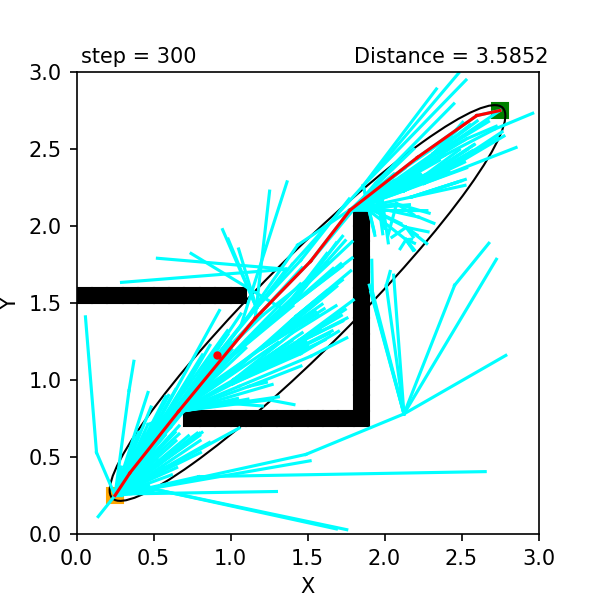

In [3]:
if __name__ == "__main__":
    time_span = 30
    time_interval = 0.1
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "../csvmap/map4.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)
    world.append(InformedRRTstar(world, R=5, ratioPointGoal=0.0))
    
    world.draw()
    #world.ani.save('input.gif', writer='pillow', fps=100)    #アニメーション保存